# Imports

In [94]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "team_select_poc"
os.environ['LANGCHAIN_API_KEY'] = "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"

In [95]:
from typing import Annotated, Literal, Dict, List, Tuple, Any
from pydantic import BaseModel
from operator import add
from IPython.display import Image, display, Markdown
from langchain.agents import (
    AgentExecutor,
    create_openai_tools_agent,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain.callbacks.base import BaseCallbackHandler
from langchain.schema import AgentAction
from langchain_openai import ChatOpenAI


import langgraph
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import AnyMessage, add_messages
from chains import get_finish_chain, get_supervisor_chain
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage 


In [96]:
from datetime import datetime
from llms import llm
from config import setup_environment

setup_environment()

# ALL IMPORTS
# from tools import financial_metrics_tools, news_sentiment_tools, market_intelligence_tools
# from prompts import get_financial_metrics_agent_prompt, get_news_sentiment_agent_prompt, get_market_intelligence_agent_prompt
# from sql_agent import query_database
# from datetime import datetime
# from llms import llm

def disp(text):
    display(Markdown(text))
    return

# LLM

In [97]:
llm

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x12f1dd220>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x12f1deea0>, root_client=<openai.OpenAI object at 0x12f118d10>, root_async_client=<openai.AsyncOpenAI object at 0x12f1dd280>, model_name='gpt-4o-mini', temperature=0.2, model_kwargs={}, openai_api_key=SecretStr('**********'))

# Config

In [98]:
settings = {
                "model": "gpt-4o-mini",
                "temperature": 0.3,
            }

# Callbacks

In [99]:
class CustomConsoleCallbackHandler(BaseCallbackHandler):
    def __init__(self):
        """Initialize the handler"""
        self.current_agent_name = None
        super().__init__()

    def write_agent_name(self, name: str):
        """Display agent name"""
        self.current_agent_name = name
        print(f"\n=== Agent: {name} ===")

    def on_tool_start(self, serialized: Dict[str, Any], input_str: str, **kwargs):
        """Display tool execution start"""
        print(f"\n🔧 Using tool: {serialized['name']}")

    def on_tool_end(self, output: str, **kwargs):
        """Display tool execution result"""
        print("\n📤 Tool output:")
        print("-" * 50)
        print(output)
        print("-" * 50)

    def on_agent_action(self, action: AgentAction, **kwargs):
        """Display agent action"""
        print(f"\n🎯 Action: {action.tool}")
        print("Input:")
        print("-" * 50)
        print(action.tool_input)
        print("-" * 50)

    def on_llm_start(self, serialized: Dict[str, Any], prompts: list[str], **kwargs):
        """Display when LLM starts processing"""
        print("\n🤔 Processing...")

    def on_llm_end(self, response, **kwargs):
        """Display final LLM response"""
        if hasattr(response, 'generations') and response.generations:
            print("\n Final LLM Response:")
            print("-" * 50)
            print(response.generations[0][0].text)
            print("-" * 50)

    def on_tool_error(self, error: str, **kwargs):
        """Display tool errors"""
        print(f"\n❌ Error: {error}")

In [102]:
def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str, max_iterations: int = 2,  return_intermediate_steps: bool = True) -> AgentExecutor:
    """
    Creates an agent using the specified ChatOpenAI model, tools, and system prompt.

    Args:
        llm : LLM to be used to create the agent.
        tools (list): The list of tools to be given to the worker node.
        system_prompt (str): The system prompt to be used in the agent.

    Returns:
        AgentExecutor: The executor for the created agent.
    """
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, max_iterations = max_iterations, return_intermediate_steps = return_intermediate_steps, verbose = True)
    return executor

**GET TOOLS CALL EVAL STATS**

In [101]:
def get_tools_call_eval_stats(result: Dict):
    """Helper function to format the output and store evaluation stats"""
    print("\n📊 TOOL EVALUATION SUMMARY")
    print("=" * 50)
    
    # Create stats dictionary to store in state
    run_stats = {
        "timestamp": datetime.now(),
        "all_tools_used": result["all_tools_used"],
        "tool_counts": result['tool_usage']['call_counts'],
        "errors": {
            "invalid_tools": result['tool_usage']['errors']['invalid_tools'],
            "execution_errors": result['tool_usage']['errors']['execution_errors'],
            "parser_errors": result['tool_usage']['errors']['parser_errors']
        }
    }
    
    # Print evaluation results
    all_tools_status = "✅" if result["all_tools_used"] else "❌"
    print(f"\n🎯 Overall Status:")
    print(f"  • All Required Tools Used: {all_tools_status}")
    
    print(f"\n📋 Tool Inventory:")
    print(f"  • Available Tools: {', '.join(result['tool_usage']['available_tools'])}")
    print(f"  • Successfully Used: {', '.join(result['tool_usage']['used_tools'])}")
    print(f"  • Not Used: {', '.join(result['tool_usage']['unused_tools'])}")
    
    print("\n📈 Usage Statistics:")
    for tool, count in result['tool_usage']['call_counts'].items():
        status = "✅" if count > 0 else "❌"
        print(f"  {status} {tool}: {count} calls")
    
    # Error Summary
    has_errors = any(len(errs) > 0 for errs in result['tool_usage']['errors'].values())
    if has_errors:
        print("\n⚠️ Error Summary:")
        errors = result['tool_usage']['errors']
        
        if errors['invalid_tools']:
            print("\n  Invalid Tool Attempts:")
            for err in errors['invalid_tools']:
                print(f"  • Requested: {err['requested']}")
                print(f"    Available: {', '.join(err['available'])}")
        
        if errors['execution_errors']:
            print("\n  Tool Execution Errors:")
            for err in errors['execution_errors']:
                print(f"  • Tool: {err['tool']}")
                print(f"    Input: {err['input']}")
                print(f"    Error: {err['error']}")
        
        if errors['parser_errors']:
            print("\n  Parser Errors:")
            for err in errors['parser_errors']:
                print(f"  • Input: {err['input']}")
                print(f"    Error: {err['error']}")
    
    print("\n🔍 Detailed Tool Execution Log:")
    for step in result["tools_used"]:
        status_emoji = {
            "success": "✅",
            "parser_error": "🔍",
            "invalid_tool": "❌",
            "execution_error": "⚠️"
        }.get(step['status'], "❓")
        
        print(f"\n  {status_emoji} Tool: {step['tool']}")
        print(f"    Status: {step['status']}")
        print(f"    Input: {step['input']}")
        if step['status'] == "success":
            print(f"    Output: {str(step['output'])[:100]}...")  # Truncate long outputs
    
    print("\n" + "=" * 50)
    
    return run_stats

# Testing DB

In [103]:
# Add these imports if not already present
import pandas as pd
import sqlite3

# Create a connection to your database
conn = sqlite3.connect('stock_db.db')

def show_tables_info():
    conn = sqlite3.connect('stock_db.db')
    
    # Get all tables and their sizes
    tables_query = """
    SELECT 
        name as table_name,
        (SELECT COUNT(*) FROM sqlite_master WHERE type='table') as row_count
    FROM sqlite_master 
    WHERE type='table';
    """
    tables = pd.read_sql_query(tables_query, conn)
    
    print("📊 Database Tables:")
    print("=" * 30)
    for _, row in tables.iterrows():
        print(f"• {row['table_name']}")
    
    conn.close()

# Show tables
show_tables_info()

# Examples of executing DB queries:

# Method 1: Using pandas (good for returning DataFrames)
def query_with_pandas(sql_query):
    conn = sqlite3.connect('stock_db.db')
    result = pd.read_sql_query(sql_query, conn)
    conn.close()
    return result

# Method 2: Using sqlite3 directly (more control)
def query_with_sqlite(sql_query):
    conn = sqlite3.connect('stock_db.db')
    cursor = conn.cursor()
    cursor.execute(sql_query)
    result = cursor.fetchall()
    conn.close()
    return result

# Example queries:
example_query = "SELECT * FROM fundamentals WHERE ticker = 'AAPL' AND date LIKE '2024%';"

# Using pandas
print("\nUsing pandas:")
result_df = query_with_pandas(example_query)
display(result_df)

# Using sqlite3
print("\nUsing sqlite3:")
result_list = query_with_sqlite(example_query)
for row in result_list:
    print(row)

📊 Database Tables:
• assets_liabilities
• fundamentals
• price
• price_fundamentals
• ratios
• revenue_profit
• industry_pe_ratios
• industry_ticker_mapping
• technicals

Using pandas:


,ticker,date,ttm_net_eps,pe_ratio,ttm_sales_per_share,book_value_per_share,ttm_fcf_per_share,current_assets,current_ratio,current_assets_inventory,...,gross_profit,operating_income,ebitda,net_income,eps_earnings_per_share_diluted,shares_outstanding,ps_ratio,pb_ratio,pfcf_ratio,total_assets



Using sqlite3:


# SQL AGENT .PY !

In [104]:
# from langchain_openai import ChatOpenAI
# from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
# from langgraph.graph import END, StateGraph, START
from typing_extensions import TypedDict
# from config import setup_environment
# from llms import llm

db_loc = "stock_db.db"
db = SQLDatabase.from_uri(f"sqlite:///{db_loc}")
database_schema = db.get_table_info()

# Create SQL toolkit and tools
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

# Define the state
# class State(TypedDict):
#     messages: Annotated[list[AnyMessage], add_messages]

In [105]:
from langgraph.graph import MessagesState
  
class SQLAgentState(MessagesState): # sql_agent_internal_state
    callback: Any # remove later
    agent_tools: List[Any] # list of tools available to the SQLAgent
    date_available: str
    relevant_tables: Dict[str, Any] = {
        "tables": [],  # List of relevant tables
        "explanation": ""  # Explanation for table selection or why no tables are relevant
    }
    response: str  # Will contain table names or error message
    date_available: str 
    wrong_generated_queries = Annotated[List[Dict[str, Any]], add] # This will track details about wrong queries generated in the generate_query node
    wrong_formatted_results  = Annotated[List[Dict[str, Any]], add] 

    

In [106]:
tools

[QuerySQLDataBaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x343d65bb0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x343d65bb0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x343d65bb0>),
 QuerySQLCheckerTool(description='Use this tool to double check if your 

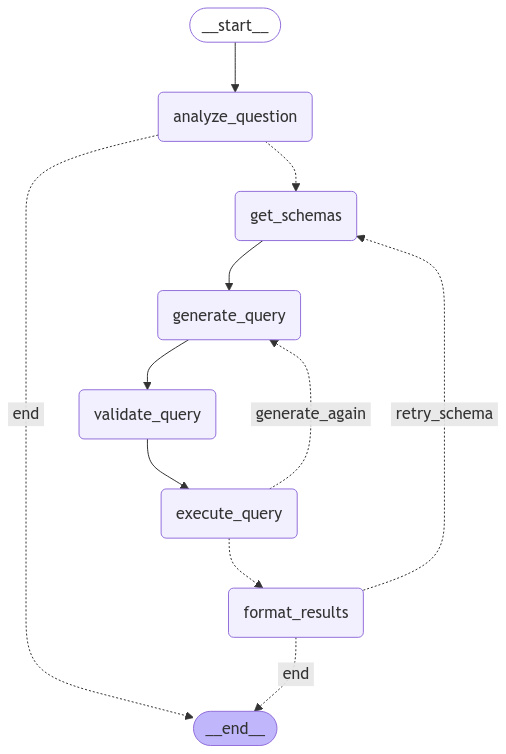

In [129]:
db_latest_date = "2022-09-30"

class AnalyzedQuestion(BaseModel):
    relevant_tables: Dict[str, Any] = {
        "tables": [],  # List of relevant tables
        "explanation": ""  # Explanation for table selection or why no tables are relevant
    }
    response: str  # Will contain table names or error message
    date_available: str  # Default to "true" if no date mentioned

SQL_AGENT_ANALYZE_PROMPT = """You are a financial data SQL expert. Analyze the user's question to determine which tables contain relevant information and date availability.

Available tables: {tables}
Schema information: {schema}

Guidelines:
1. For financial metrics, always check both 'fundamentals' and 'price' tables
2. For company analysis, consider historical data patterns
3. For any company mentioned, identify its ticker symbol by:
   - Looking for explicit ticker mentions (e.g. AAPL, MSFT)
   - Converting company names to tickers (e.g. Apple -> AAPL)
   - Using your knowledge of common company-ticker mappings
        Examples:
        - Apple/AAPL
        - Microsoft/MSFT
        - Google/GOOGL
        - Amazon/AMZN
        - Tesla/TSLA

Your response must be in this exact JSON format:
{{
    "relevant_tables": {{
        "tables": [<list_of_tables>],
        "explanation": "<explanation_string>"
    }},
    "response": "<your_response>",
    "date_available": "<true_or_false>"
}}

Where:
- relevant_tables.tables: List of table names that are relevant (empty list if none found)
- relevant_tables.explanation: REQUIRED - Detailed explanation of:
  * Why each table was chosen and what data it provides for answering the question
  * OR if no tables are relevant, a clear explanation of why none of the available tables can help
- response: Contains either table names (comma-separated) or error message
- date_available: "false" if question mentions a date after {db_latest_date}, "true" otherwise

IMPORTANT:
- If no relevant tables are found: 
  * Set relevant_tables.tables to empty list []
  * Set relevant_tables.explanation to a detailed explanation of why no tables can answer the question
  * Set response = "NO_RELEVANT_TABLES: [same explanation as in relevant_tables.explanation]"
- If date is after {db_latest_date}:
  * Set response = "We apologize, but our database only contains historical data up to {db_latest_date}. We cannot provide any information regarding dates past {db_latest_date}."
  * Set date_available = "false"
- If no date mentioned or date is valid:
  * Set date_available = "true"
- Otherwise, response should ONLY list relevant table names separated by commas
- ALWAYS provide clear explanations for your table choices or why no tables are suitable

DO NOT:
- Make assumptions about data availability
- Return tables that don't exist in the schema
- Return tables that won't help answer the question
- Skip the explanation in relevant_tables.explanation
- Include any additional text or formatting in the response"""

SQL_AGENT_QUERY_PROMPT = """You are a SQL expert. Use the following schema to help answer questions:
{schema}

Given an input question, create a syntactically correct SQLite query that joins the relevant tables.

IMPORTANT: 
- Return ONLY the SQL query without any markdown formatting or explanation
- Only query for relevant columns, not all columns
- Database contains data only up to {db_latest_date}
- When company names are mentioned, map them to their correct ticker symbols:
  * Microsoft or microsoft -> MSFT
  * Apple or apple -> AAPL
  * Google or google -> GOOGL
  * etc.
- Always include appropriate WHERE clauses to filter for the specific company mentioned
- If the requested date is after 2022-09-30, return "ERROR: Data only available up to 2022-09-30"
- If no relevant data exists for the query, return "ERROR: No relevant data available for this query"

DO NOT:
- Use markdown formatting (no ```sql or ``` tags)
- Make any DML statements (INSERT, UPDATE, DELETE, DROP etc.)
- Include any explanations before or after the query
- Default to AAPL or any other company if a specific company is mentioned
- Make assumptions about data availability beyond 2022-09-30
- Create queries for tables that don't exist in the schema"""


def clean_sql_query(query: str) -> str:
    """Remove markdown formatting and clean the SQL query"""
    # Remove markdown SQL markers
    query = query.replace("```sql", "").replace("```", "")
    # Remove any leading/trailing whitespace
    query = query.strip()
    return query

# Define node functions
def analyze_question(state: SQLAgentState) -> dict:
    """Analyze the question to determine relevant tables"""
    try:
        messages = state["messages"]
        question = messages[-1].content if messages else ""
        
        tables = list_tables_tool.invoke("")
        schema = db.get_table_info()
        print(" ALL TABLES: ", tables)
        print(" \n\nALL SCHEMAS: ", schema)
        print("______"*20 , " ANALYZE PROMPT: \n", SQL_AGENT_ANALYZE_PROMPT.format(tables=tables, schema=schema, db_latest_date = db_latest_date))
        print("______"*20 )
        messages = [
            SystemMessage(content=SQL_AGENT_ANALYZE_PROMPT.format(tables=tables, schema=schema, db_latest_date = db_latest_date)),
            HumanMessage(content=question)
        ]
        sllm = llm.with_structured_output(AnalyzedQuestion)
        analysis = sllm.invoke(messages)
        
      
      
        print("analysis: ", analysis)

        state['relevant_tables'] = analysis.relevant_tables
        state['date_available'] = analysis.date_available
        print("Set date_available to:", state['date_available'])
        print('Set state[\'relevant_tables\'][\'tables\'] to: ' , state['relevant_tables']['tables'], ' type: ', type(state['relevant_tables']['tables']))
        state['messages'] = state["messages"] + [AIMessage(content=str(analysis.response))]
        
        return state
    except Exception as e:
        print(f"Error in analyze_question: {str(e)}")
        
        state['messages'] = state["messages"] + [AIMessage(content=f"Error in analysis: {str(e)}")]
        return state

def get_schemas(state: SQLAgentState) -> dict:
    """Get schemas for relevant tables"""
    try:
        messages = state["messages"]
        tables = messages[-1].content.split(",")
        schemas = []
        for table in tables:
            table = table.strip()
            schema = get_schema_tool.invoke(table)
            schemas.append(schema)
        
        return {
            "messages": state["messages"] + [AIMessage(content="\n".join(schemas))]
        }
    except Exception as e:
        print(f"Error in get_schemas: {str(e)}")
        return {
            "messages": state["messages"] + [AIMessage(content=f"Error getting schemas: {str(e)}")]
        }

def generate_query(state: SQLAgentState) -> dict:
    """Generate SQL query based on schemas and question"""
    try:
        question = state["messages"][0].content
        schemas = state["messages"][-1].content
        
        messages = [
            SystemMessage(content=SQL_AGENT_QUERY_PROMPT.format(schema=schemas)),
            HumanMessage(content=question)
        ]
        
        query = llm.invoke(messages)
        # Clean the query before returning
        cleaned_query = clean_sql_query(query.content)
        
        return {
            "messages": state["messages"] + [AIMessage(content=cleaned_query)]
        }
    except Exception as e:
        print(f"Error in generate_query: {str(e)}")
        return {
            "messages": state["messages"] + [AIMessage(content=f"Error generating query: {str(e)}")]
        }

def validate_query(state: SQLAgentState) -> dict:
    """Validate and potentially correct the SQL query"""
    try:
        query = state["messages"][-1].content
        schema = db.get_table_info()
        
        messages = [
            SystemMessage(content="""Validate this SQL query and return ONLY the corrected query with NO additional text or explanation:
            {query}

            Schema:
            {schema}

            Check for:
            - Proper table joins
            - Correct column names
            - Appropriate WHERE clauses
            - Proper data type handling
            - SQL injection prevention
            - DO NOT modify any ticker symbols in WHERE clauses""".format(query=query, schema=schema)),
            HumanMessage(content=query)
        ]
        
        validated = llm.invoke(messages)
        # Clean the validated query before returning
        cleaned_query = clean_sql_query(validated.content)
        
        # Verify the ticker hasn't been changed
        if "WHERE" in query and "WHERE" in cleaned_query:
            original_ticker = query.split("WHERE")[1].strip().split("=")[1].strip()
            validated_ticker = cleaned_query.split("WHERE")[1].strip().split("=")[1].strip()
            if original_ticker != validated_ticker:
                return {
                    "messages": state["messages"] + [AIMessage(content=query)]  # Return original query
                }
        
        return {
            "messages": state["messages"] + [AIMessage(content=cleaned_query)]
        }
    except Exception as e:
        print(f"Error in validate_query: {str(e)}")
        return {
            "messages": state["messages"] + [AIMessage(content=f"Error validating query: {str(e)}")]
        }

def execute_query(state: SQLAgentState) -> dict:
    """Execute the SQL query"""
    try:
        query = state["messages"][-1].content
        # Make sure the query is clean before execution
        clean_query = clean_sql_query(query)
        result = db.run(clean_query)
        return {
            "messages": state["messages"] + [AIMessage(content=str(result))]
        }
    except Exception as e:
        print(f"Error in execute_query: {str(e)}")
        
        # Add to state the details about the wrong query 
        state["wrong_generated_queries"].append( {"Wrong query": clean_query , "Error message" : f"Error executing query: {str(e)}"} )
        state["messages"]= state["messages"] + [AIMessage(content=f"Error executing query: {str(e)}")]
        return state

def format_results(state: SQLAgentState) -> dict:
    """Format the query results into a readable response"""

    print(" INSIDE FORMAT RESULTS")
    try:
        # Find the SQL query from previous messages
        sql_query = None
        for message in state["messages"]:
            if isinstance(message, AIMessage) and "SELECT" in message.content:
                sql_query = message.content
                break
        
        ####################
        # NOT SURE IF THIS PART WILL BE NEEDED SINCE WE CHANGED LOGIC SO THAT IF AN ERROR HAPPENS
        # IN EXECUTE QUERY WE GO BACK TO GENERATE QUERY
        result = state["messages"][-1].content
        if result.startswith("Error:"):
            state['wrong_formatted_results'].append({"Formatted content" : result , "Error message" : result })
            
            return state # {"messages": state["messages"]}
        ##################
        messages = [
            SystemMessage(content="""Format these SQL results into a clear, readable response.
            Include both the SQL query used and the results in your response.
            Format as:
            SQL Query:
            <query>
            
            Results:
            <formatted results>"""),
            HumanMessage(content=f"Query: {sql_query}\nResults: {result}")
        ]
        
        formatted = llm.invoke(messages)
        return {
            "messages": state["messages"] + [AIMessage(content=formatted.content)]
        }
    except Exception as e:
        print(f"Error in format_results: {str(e)}")
        state['wrong_formatted_results'].append({"Formatted content" : formatted.content , "Error message:" : f"Error in format_results: {str(e)}"})
        state["messages"] = state["messages"] + [AIMessage(content=f"Error formatting results: {str(e)}")]
        return state


# Define the conditional edge function

def check_date_availability_and_tables(state: SQLAgentState) -> Literal["get_schemas", "end"]:
    """ Check whether the date enter by the user if after the latest date available in the Database"""
    print("RELEVANT TABLES FOUND : ", state['relevant_tables']['tables'])

    date_unavailable = state["date_available"].lower() == "false"
    no_relevant_tables = len(state['relevant_tables']['tables']) == 0
    
    if date_unavailable or no_relevant_tables:
        return "end"
    
    return "get_schemas"

def should_continue(state: SQLAgentState) -> Literal["retry_schema", "end"]:
    """Decide whether to retry with schema (retry_schema), or end the workflow (end)"""
    last_message = state["messages"][-1]
    content = last_message.content if isinstance(last_message, AIMessage) else ""
    
    if "Error: no such table" in content and len(state["wrong_formatted_results"]) < 3 :
        return "retry_schema"
  
    return "end"

def generate_again(state: SQLAgentState) -> Literal["generate_again" , "format_results"] :
    """Decide whether to generate the query again (generte_again), or go to format_results (format_results)"""
    last_message = state["messages"][-1]
    content = last_message.content if isinstance(last_message, AIMessage) else ""
    if "Error" in content and len(state["wrong_generated_queries"]) < 3:
        return "generate_again"
    else: 
        return "format_results"


# Create and configure the workflow
workflow = StateGraph(SQLAgentState)

# Add nodes
workflow.add_node("analyze_question", analyze_question)
workflow.add_node("get_schemas", get_schemas)
workflow.add_node("generate_query", generate_query)
workflow.add_node("validate_query", validate_query)
workflow.add_node("execute_query", execute_query)
workflow.add_node("format_results", format_results)

# Add edges
workflow.add_edge(START, "analyze_question")
workflow.add_edge("get_schemas", "generate_query")
workflow.add_edge("generate_query", "validate_query")
workflow.add_edge("validate_query", "execute_query")

# Add conditional edges
workflow.add_conditional_edges("analyze_question" , check_date_availability_and_tables, {
    "get_schemas" : "get_schemas",
    "end": END
})

workflow.add_conditional_edges(
    "execute_query", 
    generate_again,
    {
        "format_results" : "format_results",
        "generate_again" : "generate_query"
    }

)
workflow.add_conditional_edges(
    "format_results",
    should_continue,
    {
        #"generate_again": "generate_query",
        "retry_schema": "get_schemas",
        "end": END
    }
)

# Compile the workflow
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))


In [130]:
[tool.name for tool in tools]

['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker']

In [131]:
# Create a wrapper function for easier use
def query_database(question: str):
    """
    Query the database using the agent workflow
    
    Args:
        question (str): The question to ask about the data
        
    Returns:
        str: The formatted response or error message
    """
    callback_handler = CustomConsoleCallbackHandler()


    try:
        initial_state = {
            "messages": [HumanMessage(content=question)],
            "callback": callback_handler,
            "agent_tools" : [tool.name for tool in tools],   # just the tool names
            "date_available" : "",
            "relevant_tables": {
                "tables" : [],
                "explanation" : ""
            },
            "wrong_generated_queries" : [],
            "wrong_formatted_results" : []

        }
        response = graph.invoke(initial_state)
        graph_flow = response

        print("GRAPH FLOW: ", graph_flow)
        # Extract the final response
        return graph_flow
        # if isinstance(response, dict) and "messages" in response:
        #     messages = response["messages"]
        #     final_message = messages[-1].content if messages else "No response generated"
        #     return (graph_flow, final_message)
        # return (graph_flow, response)
    except Exception as e:
        print(f"Error querying database: {str(e)}")
        return f"Error: {str(e)}"



if __name__ == "__main__":
    # Test the agent
    questions = [
        #"What are all the company stock values present in the database. provide me the unique companies (ticker) in the price table?",
        #"What is the stock price of apple - ticker AAPL for 2018?",
        #"What are the fundamental of apple - ticker AAL for 2022?",
        #"Should I buy bitcoin or Cardano?",
        #"How did the company META perform in 2020?",
        "What are the fundamentals of Nvidia (NVDA) for the FY of 2022."
        #"Provide me the financial information of microsoft like revenue profit and EBIDTA for today",
        #"What are the fundamentals of apple - ticker AAPL for today?",
        #"What is the stock price of microsoft - ticker MSFT for today?",
        #"Which is the industry pe value for microsoft?",
        
    ]
    
    responses = []
    for question in questions:
        print("\nQuestion:", question)
        print("\n")
        response = query_database(question)
        responses.append(response)
        print("Response's last message:", response["messages"][-1])
        print("=" * 80)


Question: What are the fundamentals of Nvidia (NVDA) for the FY of 2022.


 ALL TABLES:  assets_liabilities, fundamentals, industry_pe_ratios, industry_ticker_mapping, price, price_fundamentals, ratios, revenue_profit, technicals
 

ALL SCHEMAS:  
CREATE TABLE assets_liabilities (
	ticker TEXT, 
	date TEXT, 
	total_assets REAL, 
	cash_on_hand REAL, 
	long_term_debt_excl_capitalized_leases REAL, 
	total_liabilities REAL, 
	total_share_holder_equity REAL
)

/*
3 rows from assets_liabilities table:
ticker	date	total_assets	cash_on_hand	long_term_debt_excl_capitalized_leases	total_liabilities	total_share_holder_equity
AAPL	2022-09-30	352755.0	48304.0	98959.0	302083.0	50672.0
AAPL	2022-06-30	336309.0	48231.0	94700.0	278202.0	58107.0
AAPL	2022-03-31	350662.0	51511.0	103323.0	283263.0	67399.0
*/


CREATE TABLE fundamentals (
	ticker TEXT, 
	date TEXT, 
	ttm_net_eps REAL, 
	pe_ratio REAL, 
	ttm_sales_per_share REAL, 
	book_value_per_share REAL, 
	ttm_fcf_per_share REAL, 
	current_assets REAL,

In [132]:
responses[0]['messages']

[HumanMessage(content='What are the fundamentals of Nvidia (NVDA) for the FY of 2022.', additional_kwargs={}, response_metadata={}, id='dc5aaf58-f796-4da2-a4e5-f03aec780bd3'),
 AIMessage(content='fundamentals,price', additional_kwargs={}, response_metadata={}, id='6af0440c-c587-4195-8d12-f85b40e683b8')]

In [125]:
responses[0]['relevant_tables']

{'tables': [], 'explanation': ''}

Edits:

- added check to see if date is after the date of the creation of the database.
- changed logic if an error in the execution occurs
- retry only 1 more time (max 2 iterations) when it gets something wrong
- changed input prompt, added date availability to check date

# Evaluation Example

In [76]:
!pip install seaborn --quiet


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [77]:
# wrong_generated_queries = response['wrong_generated_queries']
# wrong_formatted_results = response['wrong_formatted_results']

wrong_generated_queries = [
    {
        "Wrong query": """SELECT ticker, revenue, net_income 
        FROM fundamentals 
        WHERE ticker = 'AAPL' AND date = '2024-01-01'""",
        "Error message": "Error executing query: no such column: revenue"
    },
    {
        "Wrong query": """SELECT p.close_price, f.eps 
        FROM prices p 
        JOIN fundamentals f ON p.ticker = f.ticker 
        WHERE p.ticker = 'MSFT'""",
        "Error message": "Error executing query: no such table: prices"
    },
    {
        "Wrong query": """SELECT * FROM fundamentals 
        WHERE ticker = 'GOOGL' 
        ORDER BY date DESC LIMIT invalid_number""",
        "Error message": "Error executing query: near 'invalid_number': syntax error"
    }
]



wrong_formatted_results = [
    {
        "Formatted content": """Unable to format Apple financial data.
        Query attempted:
        SELECT ticker, revenue, net_income 
        FROM fundamentals 
        WHERE ticker = 'AAPL' AND date = '2024-01-01'
        
        Note: Data only available until 2022-09-30.""",
        "Error message": "Error in format_results: Invalid date format - data only available until 2022-09-30"
    },
    {
        "Formatted content": """Failed to format Google's metrics.
        Query attempted:
        SELECT p.ticker, p.close_price, f.revenue 
        FROM price p 
        JOIN fundamentals f ON p.ticker = f.ticker 
        WHERE p.ticker = 'GOOGL'
        
        Error: Missing date in JOIN condition.""",
        "Error message": "Error in format_results: Missing date condition in JOIN clause"
    },
    {
        "Formatted content": """Microsoft financial metrics:
        Revenue: $394.3B
        Net Income: $94.7B
        Date: 2022-12-31
        
        Error: Date beyond available range (2022-09-30).""",
        "Error message": "Error in format_results: Attempted to format results for date beyond available data range"
    }
]

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_sql_agent_errors(error_list, title, ax):
    """
    Create a visualization of SQL Agent execution errors.
    
    Args:
        error_list (list): List of dictionaries containing error information
        title (str): Title for the plot
        ax: Matplotlib axis to plot on
    """
    # Modern color palette - using blues and purples
    colors = ['#7986CB', '#9575CD', '#64B5F6', '#4DB6AC', '#7E57C2']
    if len(error_list) > len(colors):
        colors = colors * (len(error_list) // len(colors) + 1)
    
    # Create the horizontal bar plot
    y = np.arange(len(error_list))
    bars = ax.barh(y, [1] * len(error_list), 
                  color=colors[:len(error_list)], 
                  alpha=0.8,
                  height=0.7)
    
    ax.set_title(title, pad=20, fontsize=14, fontweight='bold')
    ax.set_ylabel("Iteration", fontsize=12, color='#2c3e50')
    
    # Set integer ticks for y-axis
    ax.set_yticks(y)
    ax.set_yticklabels([f"#{i+1}" for i in y], color='#2c3e50')
    
    # Remove x-axis as we're only showing occurrence
    ax.set_xticks([])
    
    # Style the spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Add error messages as centered text in bars
    for idx, error in enumerate(error_list):
        error_msg = error.get("Error message", "Unknown error")
        
        # Add error message text centered in bar
        ax.text(0.5, idx, error_msg,
                ha='center',
                va='center',
                fontsize=10,
                color='black',
                fontweight='medium',
                transform=ax.get_yaxis_transform())
    
    # Add subtle grid for better readability
    ax.grid(True, axis='x', linestyle='--', alpha=0.2, color='#7f8c8d')
    ax.set_axisbelow(True)

def visualize_sql_agent_performance(**error_lists):
    """
    Visualize SQL Agent errors with flexible input handling.
    
    Args:
        **error_lists: Dictionary of error lists with their titles
        Example: visualize_sql_agent_performance(
            query_errors={"data": query_list, "title": "Query Generation Errors"},
            format_errors={"data": format_list, "title": "Result Formatting Errors"}
        )
    """
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Filter out empty lists while preserving titles
    active_lists = {
        k: v for k, v in error_lists.items() 
        if v["data"]
    }
    
    # If no errors in any list
    if not active_lists:
        plt.figure(figsize=(10, 5), facecolor='white')
        plt.text(0.5, 0.5, "No issues occurred during SQL Agent execution! 🎉", 
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=14,
                color='#2c3e50')
        plt.axis('off')
        plt.title("SQL Agent Execution Summary", 
                 pad=20, 
                 fontsize=16, 
                 color='#2c3e50',
                 fontweight='bold')
    
    # If only one list has content
    elif len(active_lists) == 1:
        plt.figure(figsize=(15, 5), facecolor='white')
        error_data = list(active_lists.values())[0]
        plot_sql_agent_errors(error_data["data"], error_data["title"], plt.gca())
    
    # If multiple lists have content
    else:
        fig, axes = plt.subplots(len(active_lists), 1, 
                                figsize=(15, 5*len(active_lists)), 
                                facecolor='white')
        if len(active_lists) == 1:
            axes = [axes]
        
        for ax, (_, error_data) in zip(axes, active_lists.items()):
            plot_sql_agent_errors(error_data["data"], error_data["title"], ax)
        
        plt.subplots_adjust(hspace=0.3)
    
    plt.tight_layout()
    plt.show()

# Example data
wrong_queries = [
    {
        "Wrong query": "SELECT * FROM invalid_table",
        "Error message": "Table 'invalid_table' does not exist"
    }
]

wrong_results = [
    {
        "Formatted content": "Invalid format",
        "Error message": "Formatting error occurred"
    }
]



## Dummy examples to test the plot function

Example 1: Both lists empty


/var/folders/9v/0z2cy6c546g6bvh2dzly39x80000gn/T/ipykernel_69604/2350428419.py:111: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from font(s) Arial.
  plt.tight_layout()
/Users/robertagarcia/Desktop/learning/hackathon/new-venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


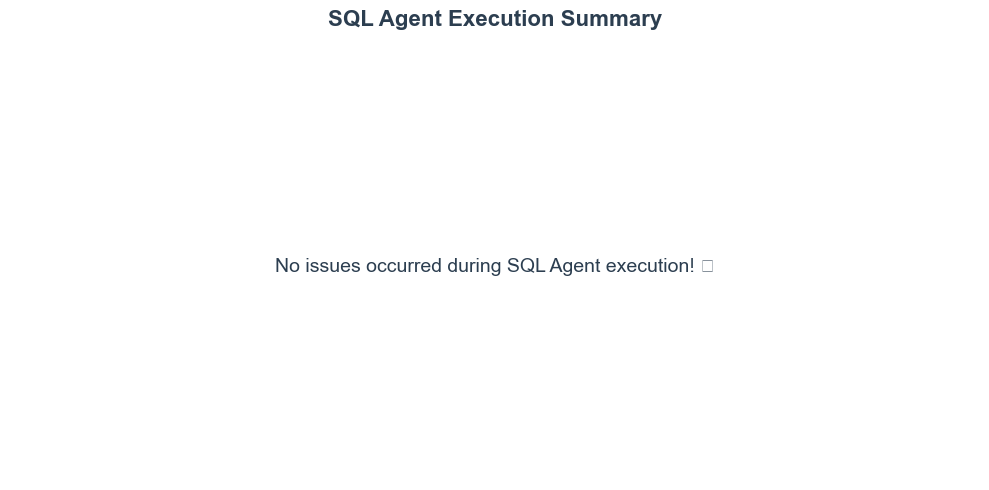


Example 2: Only query errors empty


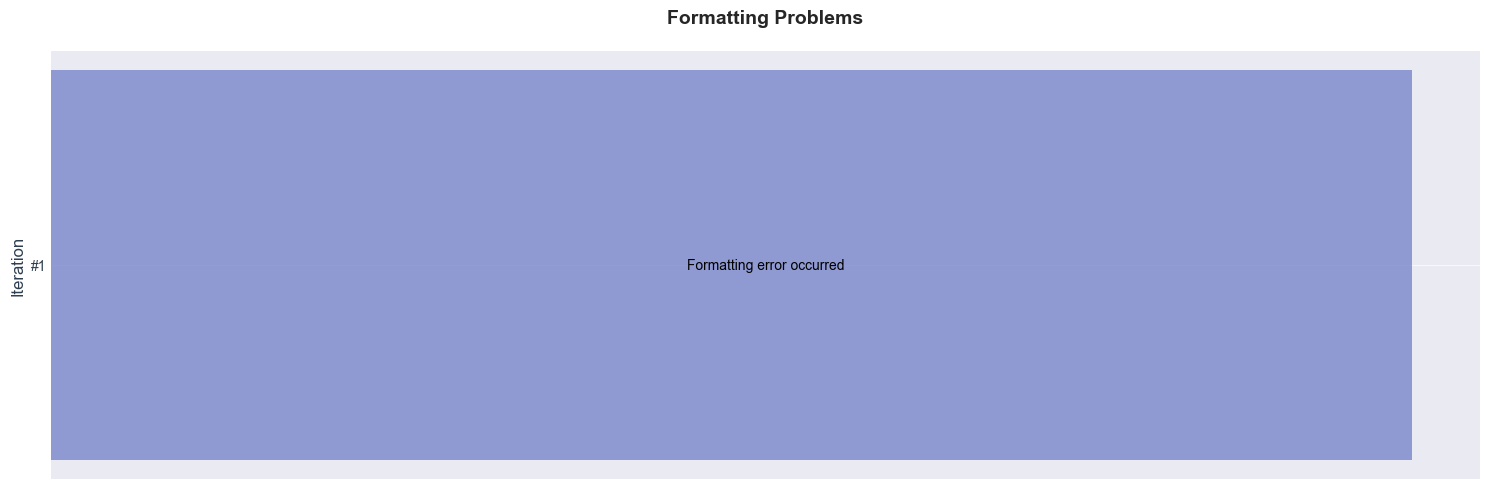


Example 3: Only formatting errors empty


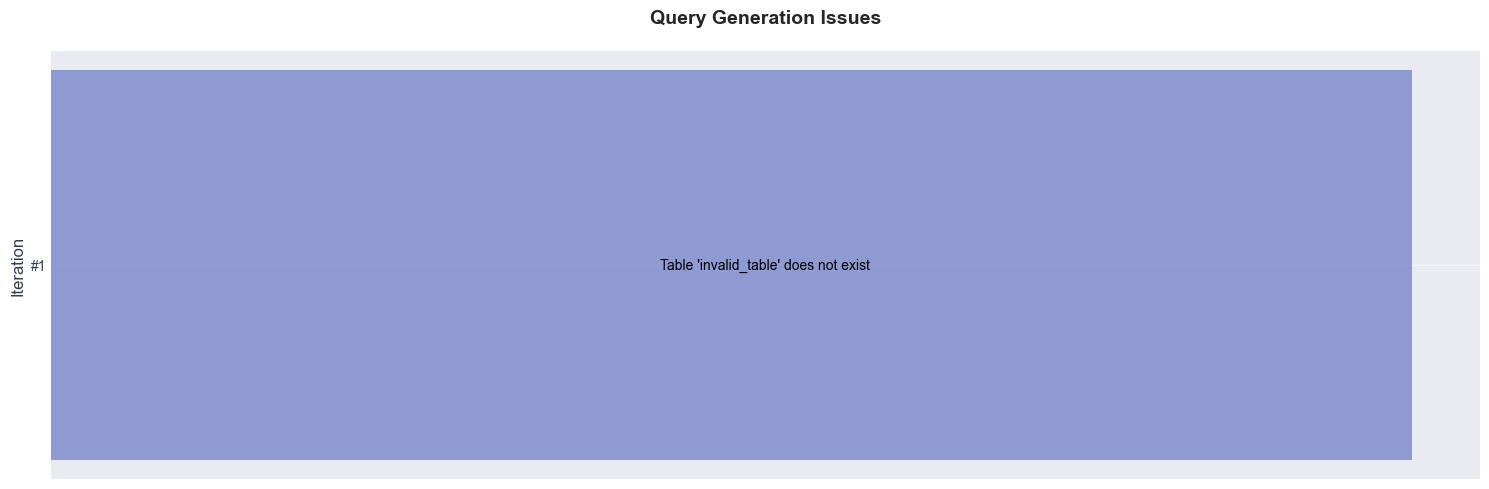


Example 4: Both lists containing content


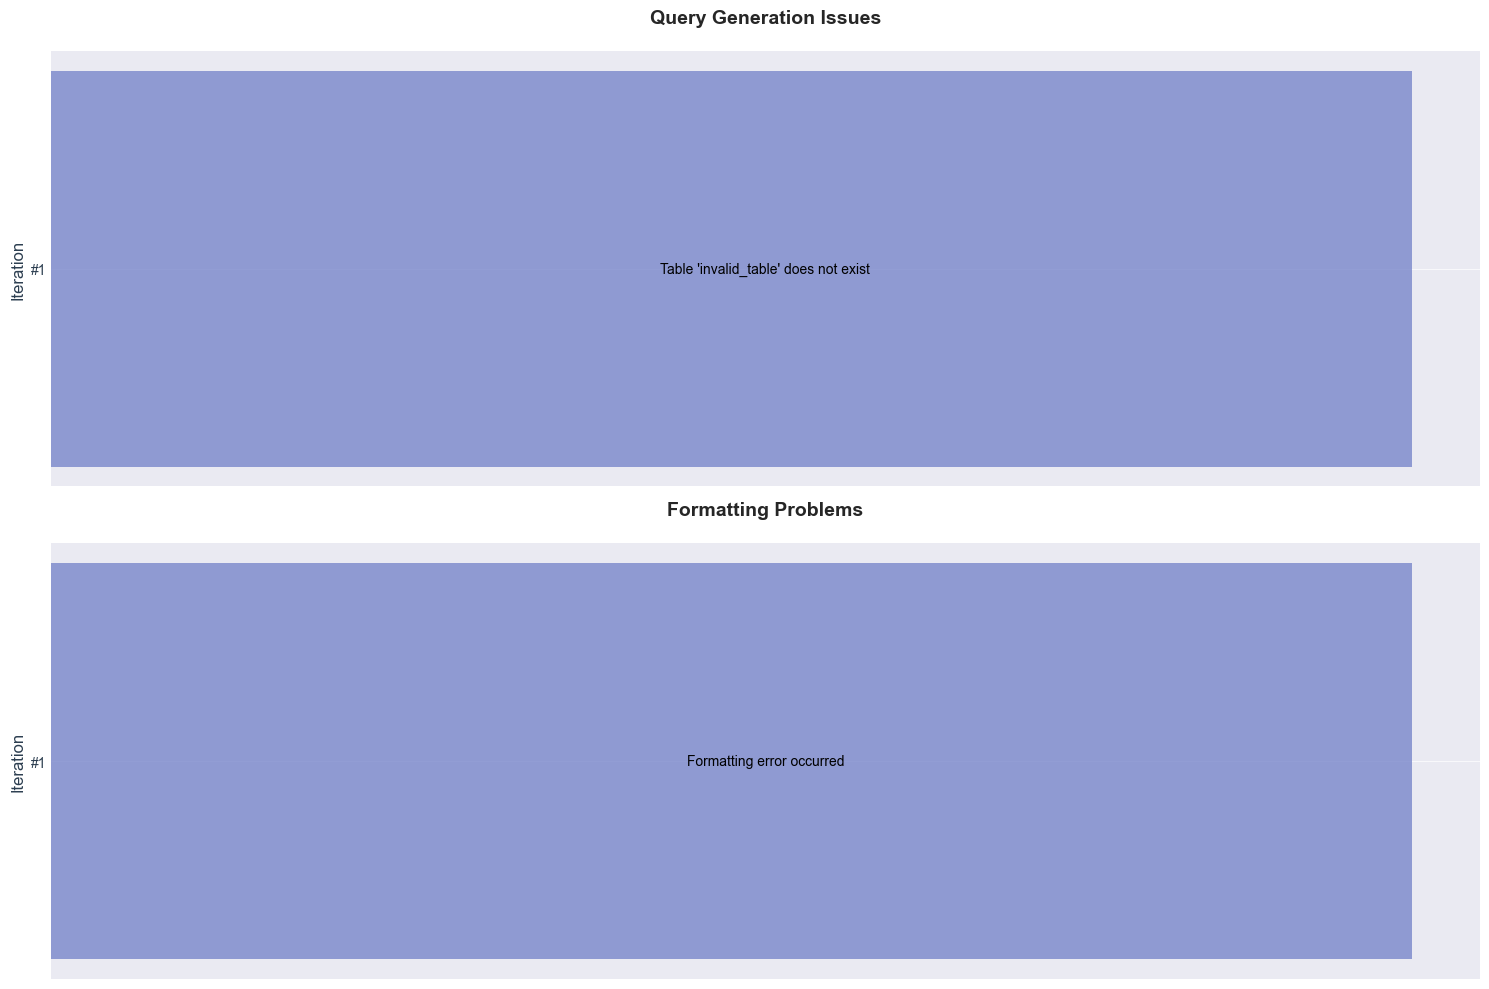

In [79]:
# Example 1: Both lists empty
print("Example 1: Both lists empty")
visualize_sql_agent_performance(
    query_errors={"data": [], "title": "Query Generation Issues"},
    format_errors={"data": [], "title": "Formatting Problems"}
)

# Example 2: Only wrong_generated_queries empty
print("\nExample 2: Only query errors empty")
visualize_sql_agent_performance(
    query_errors={"data": [], "title": "Query Generation Issues"},
    format_errors={"data": wrong_results, "title": "Formatting Problems"}
)

# Example 3: Only wrong_formatted_results empty
print("\nExample 3: Only formatting errors empty")
visualize_sql_agent_performance(
    query_errors={"data": wrong_queries, "title": "Query Generation Issues"},
    format_errors={"data": [], "title": "Formatting Problems"}
)

# Example 4: Both containing content
print("\nExample 4: Both lists containing content")
visualize_sql_agent_performance(
    query_errors={"data": wrong_queries, "title": "Query Generation Issues"},
    format_errors={"data": wrong_results, "title": "Formatting Problems"}
)

In [133]:
def format_sql_agent_errors_table(error_list, title) -> pd.DataFrame:
    """
    Create a table representation of SQL Agent execution errors.
    
    Args:
        error_list (list): List of dictionaries containing error information
        title (str): Title for the table
    
    Returns:
        pd.DataFrame: Formatted table of errors
    """
    # Create DataFrame with iteration numbers and error messages
    df = pd.DataFrame([
        {
            'Iteration': f"#{i+1}",
            'Error Message': error.get("Error message", "Unknown error")
        }
        for i, error in enumerate(error_list)
    ])
    
    return df

def tabulate_sql_agent_performance(**error_lists) -> pd.DataFrame:

    """
    Create tables for SQL Agent errors with flexible input handling.
    
    Args:
        **error_lists: Dictionary of error lists with their titles
        Example: tabulate_sql_agent_performance(
            query_errors={"data": query_list, "title": "Query Generation Errors"},
            format_errors={"data": format_list, "title": "Result Formatting Errors"}
        )
    
    Returns:
        pd.DataFrame: Combined DataFrame containing all errors or success message
    """
    # Filter out empty lists while preserving titles
    active_lists = {
        k: v for k, v in error_lists.items() 
        if v["data"]
    }
    
    # If no errors in any list
    if not active_lists:
        return pd.DataFrame({
            'Category': ['SQL Agent Execution'],
            'Status': ['Success'],
            'Details': ['No issues occurred during execution']
        })
    
    # Create tables for each error type and combine them
    all_errors = []
    for error_type, error_data in active_lists.items():
        errors_df = format_sql_agent_errors_table(error_data["data"], error_data["title"])
        errors_df['Category'] = error_data["title"]  # Add category column
        all_errors.append(errors_df)
    
    # Combine all error DataFrames
    return pd.concat(all_errors, ignore_index=True)

In [135]:
# Example 1: Both lists empty
print("Example 1: Both lists empty")
tabulate_sql_agent_performance(
    query_errors={"data": [], "title": "Query Generation Issues"},
    format_errors={"data": [], "title": "Formatting Problems"}
)


Example 1: Both lists empty


,Category,Status,Details
0,SQL Agent Execution,Success,No issues occurred during execution


In [136]:
# Example 2: Only wrong_generated_queries empty
print("\nExample 2: Only query errors empty")
tabulate_sql_agent_performance(
    query_errors={"data": [], "title": "Query Generation Issues"},
    format_errors={"data": wrong_results, "title": "Formatting Problems"}
)



Example 2: Only query errors empty


,Iteration,Error Message,Category
0,#1,Formatting error occurred,Formatting Problems


In [138]:
# Example 3: Only wrong_formatted_results empty
print("\nExample 3: Only formatting errors empty")
tabulate_sql_agent_performance(
    query_errors={"data": wrong_queries, "title": "Query Generation Issues"},
    format_errors={"data": [], "title": "Formatting Problems"}
)



Example 3: Only formatting errors empty


,Iteration,Error Message,Category
0,#1,Table 'invalid_table' does not exist,Query Generation Issues


In [143]:
# Example 4: Both containing content
print("\nExample 4: Both lists containing content")
tabulate_sql_agent_performance(
    query_errors={"data": wrong_queries, "title": "Query Generation Issues"},
    format_errors={"data": wrong_results, "title": "Formatting Problems"}
)


Example 4: Both lists containing content


,Iteration,Error Message,Category
0,#1,Table 'invalid_table' does not exist,Query Generation Issues
1,#1,Formatting error occurred,Formatting Problems
